# Import required modules

In [1]:
import anndata
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scanpy as sc
from scnym.api import scnym_api

import sys, os, joblib
import numpy_groupies as npg
import scipy.sparse as sp
from sklearn.linear_model import LogisticRegression

In [2]:
import session_info
session_info.show()

## Read in anndata

In [3]:
adata = sc.read_h5ad('/nfs/team205/heart/anndata_objects/8regions/8reg_reichart_chaffin/FB_LVs_raw.h5ad')
adata

AnnData object with n_obs × n_vars = 285302 × 32732
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'dataset', 'disease', 'Gene', 'Clinical.dominant.mutation', 'Mutation.Type', 'Origin', 'percent_mito', 'percent_ribo', 'n_counts', 'solo_score', 'predicted_doublets_solo', 'scrublet_score_log', 'predicted_doublets_log', 'Replicate', 'cell_states_long', 'validated', 'cell_type_validated', 'sex', 'lvef', 'cell_type_leiden0.6', 'SubCluster', 'cellbender_ncount', 'cellbender_ngenes', 'cellranger_percent_mito', 'exon_prop', 'cellbender_entropy', 'cellranger_doublet_scores', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts'

In [4]:
# summarise cell type annotation
## barcodes from Chaffin
chaffin_obsnames = adata.obs_names[adata.obs['dataset']=='Chaffin_Nature_2022']

adata.obs['cell_state']=adata.obs['cell_state'].astype('str')
adata.obs.loc[chaffin_obsnames,'cell_state']=adata.obs.loc[chaffin_obsnames,'cell_type_leiden0.6'].copy()
adata.obs['cell_state']=adata.obs['cell_state'].astype('category')

pd.crosstab(adata.obs['cell_state'],adata.obs['dataset'])

dataset,Chaffin_Nature_2022,HCAv2,Reichart_Science_2022
cell_state,,,
Activated_fibroblast,5210,0,0
FB1,0,25360,0
FB2,0,2357,0
FB3,0,3049,0
FB4,0,9958,0
FB5,0,4040,0
FB6,0,1669,0
Fibroblast_I,141725,0,0
Fibroblast_II,284,0,0


In [5]:
print(adata.X.data[:10])
adata.obs['cell_state'].cat.categories

[ 1.  3.  1.  4.  3. 10.  1.  4.  5.  7.]


Index(['Activated_fibroblast', 'FB1', 'FB2', 'FB3', 'FB4', 'FB5', 'FB6',
       'Fibroblast_I', 'Fibroblast_II', 'vFB1.0', 'vFB1.1', 'vFB1.2', 'vFB2',
       'vFB3', 'vFB4'],
      dtype='object')

In [6]:
adata.obs['dataset'].value_counts()

Chaffin_Nature_2022      147219
Reichart_Science_2022     91650
HCAv2                     46433
Name: dataset, dtype: int64

## HCAv2 model

In [7]:
ref = adata[adata.obs['dataset']=='HCAv2']
ref

View of AnnData object with n_obs × n_vars = 46433 × 32732
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'dataset', 'disease', 'Gene', 'Clinical.dominant.mutation', 'Mutation.Type', 'Origin', 'percent_mito', 'percent_ribo', 'n_counts', 'solo_score', 'predicted_doublets_solo', 'scrublet_score_log', 'predicted_doublets_log', 'Replicate', 'cell_states_long', 'validated', 'cell_type_validated', 'sex', 'lvef', 'cell_type_leiden0.6', 'SubCluster', 'cellbender_ncount', 'cellbender_ngenes', 'cellranger_percent_mito', 'exon_prop', 'cellbender_entropy', 'cellranger_doublet_scores', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_

In [8]:
ref.obs['cell_state'].value_counts()

FB1    25360
FB4     9958
FB5     4040
FB3     3049
FB2     2357
FB6     1669
Name: cell_state, dtype: int64

In [ ]:
# downsize
# HCA_vCM_d = msc.downsize_cell(HCA_vCM, groupby='cell_states', n_down=2000, seed=1)
# HCA_vCM_d.obs['cell_states'].value_counts()

In [9]:
# filter genes
sc.pp.filter_genes(ref, min_cells=3)

# normalize
sc.pp.normalize_total(ref, target_sum=1e4)
sc.pp.log1p(ref)

Trying to set attribute `.var` of view, copying.


In [10]:
ref.X.data[:10]

array([1.5775752, 2.5280933, 1.5775752, 2.795621 , 2.5280933, 3.674577 ,
       1.5775752, 2.795621 , 3.0064738, 3.3287122], dtype=float32)

In [11]:
# train scNym model
scnym_api(
    adata=ref,
    task='train',
    groupby='cell_state',
    out_path='/nfs/team205/heart/scnym/model_HCAv2_FBs',
    config='new_identity_discovery',
)

No CUDA device found.
Computations will be performed on the CPU.
Add a CUDA compute device to improve speed dramatically.

No unlabeled data was found.
Did you forget to set some examples as `"Unlabeled"`?
Proceeding with purely supervised training.

X:  (46433, 27290)
y:  (46433,)
Not weighting classes and not balancing classes.
Found 2 unique domains.
Training...
Saving best model weights..._____________|
Saved best weights.
Saving best model weights..._____________|
Saved best weights.
Saving best model weights..._____________|
Saved best weights.
>>>>> 49/99|--------------________________|
Early stopping at epoch 49
>>>>>
Training complete.

Evaluating model.
EVAL LOSS:  1.0301646903941506
EVAL ACC :  0.7934969853574505
Predictions | Labels
[[3 3]
 [0 0]
 [4 4]
 [4 4]
 [0 0]
 [0 4]
 [0 0]
 [0 3]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]]


## Query: Chaffin

In [7]:
que_cf = adata[adata.obs['dataset']=='Chaffin_Nature_2022']
que_cf

View of AnnData object with n_obs × n_vars = 147219 × 32732
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'dataset', 'disease', 'Gene', 'Clinical.dominant.mutation', 'Mutation.Type', 'Origin', 'percent_mito', 'percent_ribo', 'n_counts', 'solo_score', 'predicted_doublets_solo', 'scrublet_score_log', 'predicted_doublets_log', 'Replicate', 'cell_states_long', 'validated', 'cell_type_validated', 'sex', 'lvef', 'cell_type_leiden0.6', 'SubCluster', 'cellbender_ncount', 'cellbender_ngenes', 'cellranger_percent_mito', 'exon_prop', 'cellbender_entropy', 'cellranger_doublet_scores', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total

In [8]:
que_cf.X.data[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 4., 1.], dtype=float32)

In [9]:
# filter genes and cells
sc.pp.filter_genes(que_cf, min_cells=3)

# normalize
sc.pp.normalize_total(que_cf, target_sum=1e4)
sc.pp.log1p(que_cf)

Trying to set attribute `.var` of view, copying.


In [10]:
scnym_api(
    adata=que_cf,
    task='predict',
    key_added='scNym',
    config='new_identity_discovery',
    trained_model='/nfs/team205/heart/scnym/model_HCAv2_FBs',
)

que_cf.obs['scNym']=que_cf.obs['scNym'].astype('category')

No CUDA device found.
Computations will be performed on the CPU.
Add a CUDA compute device to improve speed dramatically.

Loaded model predicting 6 classes from 27290 features
['FB1' 'FB2' 'FB3' 'FB4' 'FB5' 'FB6']
Building a classification matrix...


mapping genes: 28265it [00:37, 763.79it/s]
Finding cell types:   0%|          | 0/144 [00:00<?, ?it/s]

Found 26570 common genes.
Predicting cell types...


Finding cell types: 100%|██████████| 144/144 [01:06<00:00,  2.16it/s]


Extracting model embeddings...


In [11]:
que_cf.obs['disease_donor']=que_cf.obs['disease'].astype('str')+'_'+que_cf.obs['donor'].astype('str')

[]

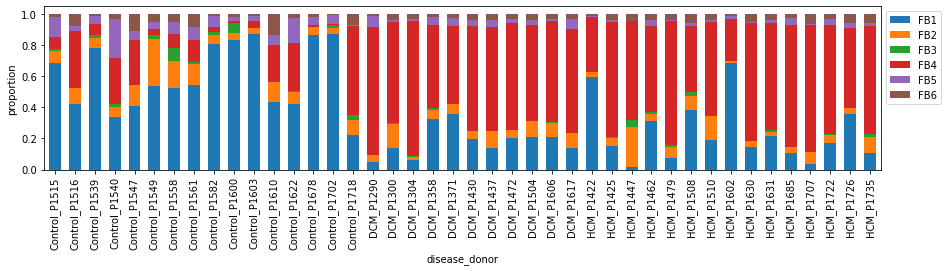

In [12]:
tmp = pd.crosstab(que_cf.obs['disease_donor'], que_cf.obs['scNym'], normalize='index')

plt.rcParams['figure.figsize'] = 15,3

# tmp.plot.bar().legend(loc=1)
ax = tmp.plot.bar(stacked=True,width=0.6)
ax.grid(False)
ax.set_ylabel('proportion')
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot()

In [13]:
que_cf.write('/nfs/team205/heart/anndata_objects/8regions/8reg_reichart_chaffin/FB_LVs_Chaffin_scnym.h5ad')

... storing 'disease_donor' as categorical


## Query: Reichart

In [14]:
que_rc = adata[adata.obs['dataset']=='Reichart_Science_2022']
que_rc

View of AnnData object with n_obs × n_vars = 91650 × 32732
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'dataset', 'disease', 'Gene', 'Clinical.dominant.mutation', 'Mutation.Type', 'Origin', 'percent_mito', 'percent_ribo', 'n_counts', 'solo_score', 'predicted_doublets_solo', 'scrublet_score_log', 'predicted_doublets_log', 'Replicate', 'cell_states_long', 'validated', 'cell_type_validated', 'sex', 'lvef', 'cell_type_leiden0.6', 'SubCluster', 'cellbender_ncount', 'cellbender_ngenes', 'cellranger_percent_mito', 'exon_prop', 'cellbender_entropy', 'cellranger_doublet_scores', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_

In [15]:
# filter genes and cells
sc.pp.filter_genes(que_rc, min_cells=3)

# normalize
sc.pp.normalize_total(que_rc, target_sum=1e4)
sc.pp.log1p(que_rc)

que_rc.X.data[:10]

Trying to set attribute `.var` of view, copying.


array([2.3290167, 3.3604977, 2.3290167, 3.3604977, 2.3290167, 2.3290167,
       2.3290167, 2.3290167, 2.3290167, 2.3290167], dtype=float32)

In [16]:
# predict
scnym_api(
    adata=que_rc,
    task='predict',
    key_added='scNym',
    config='new_identity_discovery',
    trained_model='/nfs/team205/heart/scnym/model_HCAv2_FBs',
)

que_rc.obs['scNym']=que_rc.obs['scNym'].astype('category')

No CUDA device found.
Computations will be performed on the CPU.
Add a CUDA compute device to improve speed dramatically.

Loaded model predicting 6 classes from 27290 features
['FB1' 'FB2' 'FB3' 'FB4' 'FB5' 'FB6']
Building a classification matrix...


mapping genes: 27292it [00:29, 917.61it/s]
Finding cell types:   0%|          | 0/90 [00:00<?, ?it/s]

Found 26235 common genes.
Predicting cell types...


Finding cell types: 100%|██████████| 90/90 [00:39<00:00,  2.29it/s]


Extracting model embeddings...


In [17]:
que_rc.obs['disease_donor']=que_rc.obs['disease'].astype('str')+'_'+que_rc.obs['donor'].astype('str')

[]

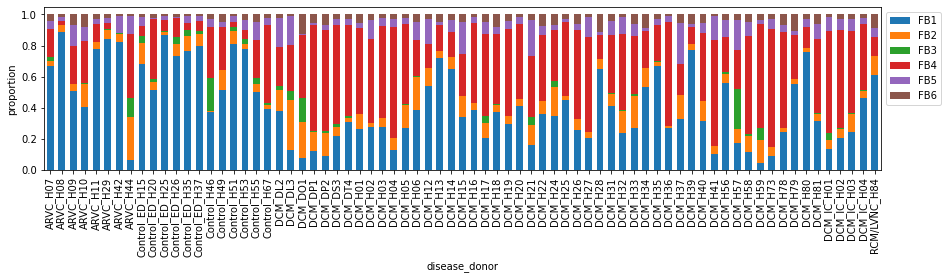

In [18]:
tmp = pd.crosstab(que_rc.obs['disease_donor'], que_rc.obs['scNym'], normalize='index')

plt.rcParams['figure.figsize'] = 15,3

# tmp.plot.bar().legend(loc=1)
ax = tmp.plot.bar(stacked=True,width=0.6)
ax.grid(False)
ax.set_ylabel('proportion')
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot()

In [19]:
que_rc.write('/nfs/team205/heart/anndata_objects/8regions/8reg_reichart_chaffin/FB_LVs_Reichart_scnym.h5ad')

... storing 'disease_donor' as categorical


## Statistical analysis

In [5]:
import scipy
from statsmodels.stats.multitest import multipletests

In [3]:
# read in
que_cf = sc.read_h5ad('/nfs/team205/heart/anndata_objects/8regions/8reg_reichart_chaffin/FB_LVs_Chaffin_scnym.h5ad',
                     backed='r')
que_cf

AnnData object with n_obs × n_vars = 147219 × 28265 backed at '/nfs/team205/heart/anndata_objects/8regions/8reg_reichart_chaffin/FB_LVs_Chaffin_scnym.h5ad'
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'dataset', 'disease', 'Gene', 'Clinical.dominant.mutation', 'Mutation.Type', 'Origin', 'percent_mito', 'percent_ribo', 'n_counts', 'solo_score', 'predicted_doublets_solo', 'scrublet_score_log', 'predicted_doublets_log', 'Replicate', 'cell_states_long', 'validated', 'cell_type_validated', 'sex', 'lvef', 'cell_type_leiden0.6', 'SubCluster', 'cellbender_ncount', 'cellbender_ngenes', 'cellranger_percent_mito', 'exon_prop', 'cellbender_entropy', 'cellrang

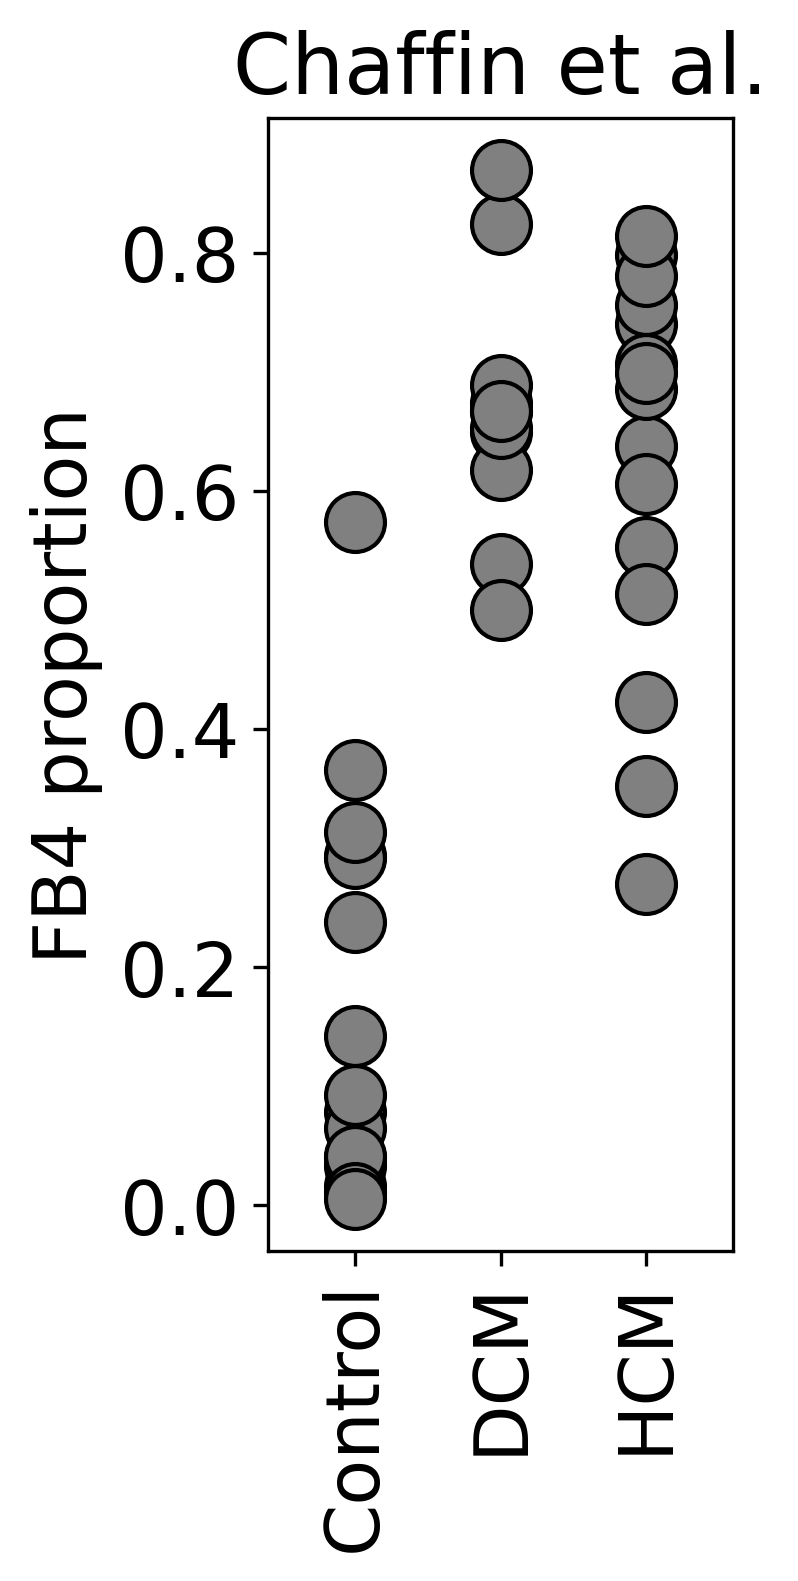

Result of stats
{'conrtol_vs_DCM': RanksumsResult(statistic=-4.2437884324905095, pvalue=2.1977756950446486e-05), 'conrtol_vs_HCM': RanksumsResult(statistic=-4.348131782731521, pvalue=1.37302098824242e-05)}

Adjusted p-values for multiple comparisons


{'conrtol_vs_DCM': 4.395551390089297e-05,
 'conrtol_vs_HCM': 2.74604197648484e-05}

In [8]:
# Chaffin
df = que_cf.obs[['disease_donor','scNym']].copy()
df['FB4']=df['scNym']=='FB4'
df.drop(['scNym'],axis=1,inplace=True)

df=df.groupby('disease_donor').apply(lambda x:np.sum(x)/len(x))
df['disease']=[x.split('_')[0] for x in df.index]

plt.rcParams['figure.figsize'] = 2,5
plt.rcParams["figure.dpi"] = 300
plt.scatter(x='disease',y='FB4',data=df,c='grey',edgecolors='black',s=200)
plt.margins(x=0.3)
plt.xticks(fontsize=18,rotation=90)
plt.yticks(fontsize=18)
plt.ylabel('FB4 proportion',fontsize=18)
plt.title('Chaffin et al.', fontsize=20)
plt.savefig('/home/jovyan/projects/P56_pre-clinical-fibrosis/notebooks/figures/FB4_chaffin.pdf',
           bbox_inches='tight')
plt.show()

# p values
stats_res = {}
stats_res['conrtol_vs_DCM'] = scipy.stats.ranksums(df[df['disease']=='Control']['FB4'],
                                                    df[df['disease']=='DCM']['FB4'])
stats_res['conrtol_vs_HCM'] = scipy.stats.ranksums(df[df['disease']=='Control']['FB4'],
                                                    df[df['disease']=='HCM']['FB4'])
print('Result of stats')
print(stats_res)

# pvalue collection
pval_adjusted = {}
res = multipletests([x[1] for x in stats_res.values()], method='bonferroni')
for i,k in enumerate(stats_res.keys()):
    pval_adjusted[k] = res[1][i]

print('')
print('Adjusted p-values for multiple comparisons')
pval_adjusted

In [9]:
# read in
que_rc = sc.read_h5ad('/nfs/team205/heart/anndata_objects/8regions/8reg_reichart_chaffin/FB_LVs_Reichart_scnym.h5ad',
                     backed='r')
que_rc

AnnData object with n_obs × n_vars = 91650 × 27292 backed at '/nfs/team205/heart/anndata_objects/8regions/8reg_reichart_chaffin/FB_LVs_Reichart_scnym.h5ad'
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'dataset', 'disease', 'Gene', 'Clinical.dominant.mutation', 'Mutation.Type', 'Origin', 'percent_mito', 'percent_ribo', 'n_counts', 'solo_score', 'predicted_doublets_solo', 'scrublet_score_log', 'predicted_doublets_log', 'Replicate', 'cell_states_long', 'validated', 'cell_type_validated', 'sex', 'lvef', 'cell_type_leiden0.6', 'SubCluster', 'cellbender_ncount', 'cellbender_ngenes', 'cellranger_percent_mito', 'exon_prop', 'cellbender_entropy', 'cellrang

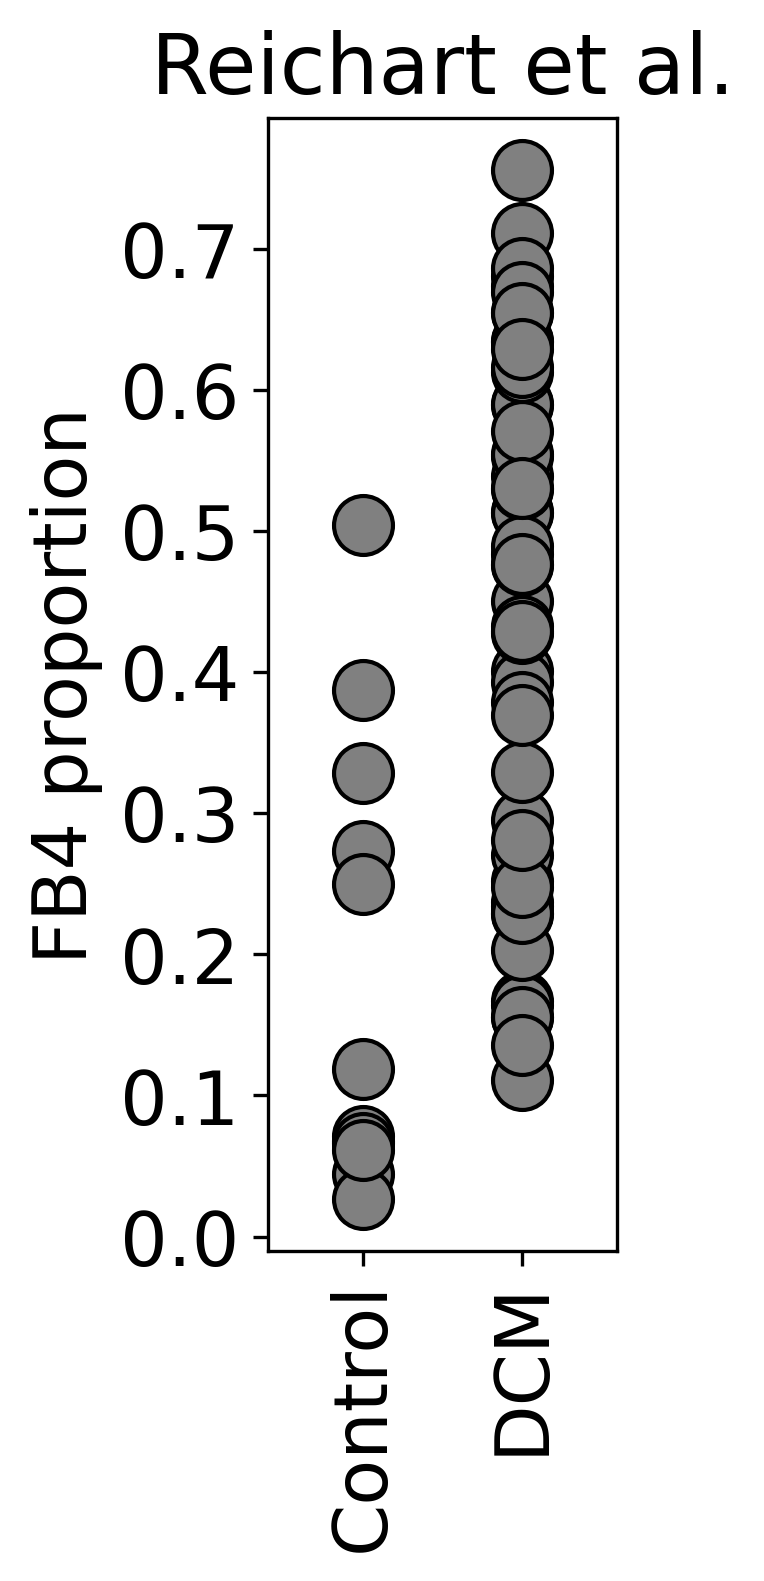

RanksumsResult(statistic=-3.801315561749642, pvalue=0.00014392985649715694)

In [10]:
# Reichart
df = que_rc.obs[['disease_donor','scNym']].copy()
df['FB4']=df['scNym']=='FB4'
df.drop(['scNym'],axis=1,inplace=True)

df=df.groupby('disease_donor').apply(lambda x:np.sum(x)/len(x))
df['disease']=[x.split('_')[0] for x in df.index]
df=df[df['disease'].isin(['Control','DCM'])]

plt.rcParams['figure.figsize'] = 1.5,5
plt.rcParams["figure.dpi"] = 300
plt.scatter(x='disease',y='FB4',data=df,c='grey',edgecolors='black',s=200)
plt.margins(x=0.6)
plt.xticks(fontsize=18,rotation=90)
plt.yticks(fontsize=18)
plt.ylabel('FB4 proportion',fontsize=18)
plt.title('Reichart et al.', fontsize=20)
plt.savefig('/home/jovyan/projects/P56_pre-clinical-fibrosis/notebooks/figures/FB4_reichart.pdf',
           bbox_inches='tight')
plt.show()

scipy.stats.ranksums(df[df['disease']=='Control']['FB4'],
                     df[df['disease']=='DCM']['FB4']
                    )